# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [15]:
#Imports
import os
import pickle
from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf
import numpy as np

from skimage import transform as transf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import random
import csv

In [4]:
## This Cell's helper functions are taken from 
## https://github.com/jmlb/Udacity-SDCND/blob/master/CarND-TrafficSigns-P2/Traffic_Signs_Recognition.ipynb
def visualize_random_images(list_imgs, X_dataset, y_dataset):
    '''
    list_imgs = list of index of images to be visualized
    '''
    _, ax = plt.subplots( len(list_imgs)//5, 5, figsize=(20,10))
    row, col = 0, 0  
    for idx in list_imgs:
        img = X_dataset[idx]
        ax[row, col].imshow(img)
        ax[row, col].annotate(int(y_dataset[idx]), xy=(2, 5), color='red', fontsize='20')

        ax[row,col].axis('off')
        col += 1
        if col == 5:
            row += 1
            col = 0
    plt.show()


def get_count_imgs_per_class(y, verbose=False):
    num_classes = len(np.unique(y))
    count_imgs_per_class = np.zeros( num_classes )

    for this_class in range( num_classes ):
        if verbose: 
            print('class {} | count {}'.format(this_class, np.sum( y  == this_class )) )
        count_imgs_per_class[this_class] = np.sum(y == this_class )
    #sanity check
    return count_imgs_per_class

def random_transform(img, angle_range=[-10, 10],
                     scale_range=[0.8, 1.2], 
                     translation_range=[-3, 3]):
    '''
    The function takes an image and performs a set of random affine transformations.
    img - original image
    ang_range - angular range of the rotation [-15,+15] deg for example
    scale_range - [0.8, 1.2]
    shear_range - [10,-10]
    translation_range : [-2, 2]
    '''
    img_height, img_width, img_depth = img.shape
    
    # Generate random parameter values
    angle_value = np.random.uniform(low=angle_range[0], high=angle_range[1], size=None)
    scaleX = np.random.uniform(low=scale_range[0], high=scale_range[1], size=None)
    scaleY = np.random.uniform(low=scale_range[0], high=scale_range[1], size=None)
    translationX = np.random.randint(low=translation_range[0], high=translation_range[1]+1, size=None)
    translationY = np.random.randint(low=translation_range[0], high=translation_range[1]+1, size=None)

    #center images to run rotation about the image center rather than [0,0] point
    center_shift = np.array( [img_height, img_width] ) / 2. -0.5
    #transformation translation of the image: image center matches [0,0] orign
    transform_center = transf.SimilarityTransform( translation = -center_shift )
    transform_uncenter = transf.SimilarityTransform( translation = center_shift )

    # Image transformation : includes rotation, shear, tranlation, zoom
    transform_aug = transf.AffineTransform( rotation = np.deg2rad( angle_value ),
                                         scale = (1/scaleY, 1/scaleX),
                                         translation = (translationY, translationX))

    # Make transformation
    full_transform = transform_center + transform_aug + transform_uncenter
    new_img = transf.warp( img, full_transform, preserve_range=True )
    
    return new_img.astype('uint8')


def data_augmentation(X_dataset, y_dataset, augm_nbr, keep_dist = True):
    '''
    X_dataset - image dataset to augment
    y_dataset - label dataset
    keep_dist - True: keep class distribution of original dataset,
                False: balance dataset,
    augm_param - is the augmentation parameter
                if keep_dist is True, increase the dataset by the factor 'augm_nbr' (2x, 5x or 10x...)
                if keep_dist is False, make all classes have same number of images: 'augm_nbr' (2500, 3000 or 4000 imgs)
    
    '''
    X_train_dtype = X_train
    n_classes = len(np.unique(y_dataset)) #number of classes in dataset
    _, img_height, img_width, img_depth = X_dataset.shape
    class_freq = get_count_imgs_per_class(y_train)
    
    if keep_dist:
        extra_imgs_per_class = np.array([augm_nbr*x for x in get_count_imgs_per_class(y_dataset)])
        
    else:
        assert (augm_nbr > np.argmax(class_freq)), 'augm_nbr must be larger than the highest class count'
        extra_imgs_per_class = augm_nbr - get_count_imgs_per_class(y_dataset) 
    
    total_extra_imgs = np.sum( extra_imgs_per_class )
    
    #if extra images needed --> run the data augmentation op 
    if total_extra_imgs > 0:
        # initialize tensor to store extra imgs, datatype same as 
        X_extra = np.zeros( ( int(total_extra_imgs), img_height, img_width, img_depth ), dtype=X_train.dtype)
        y_extra = np.zeros( int(total_extra_imgs) )
        start_idx = 0
        print('start data augmentation .....')
        for this_class in range( n_classes ):
            print('\t Class {} | Number of extra imgs {}'.format(this_class, int(extra_imgs_per_class[this_class])))
            n_extra_imgs = extra_imgs_per_class[this_class] #number of extra images to generate for this class
        
            end_idx = start_idx + n_extra_imgs
        
            if n_extra_imgs > 0:
                #get ids of all images belonging to this_class
                all_imgs_id = np.argwhere( y_dataset == this_class )
                # initialize tensor to store all the extra images for this class 
                new_imgs_x = np.zeros( ( int(n_extra_imgs), img_height, img_width, img_depth ) )
            
                for k in range( int(n_extra_imgs) ):
                    #randomly pick an original image belonging to this_class:
                    rand_id = np.random.choice( all_imgs_id[0], size=None, replace=True )
                    rand_img = X_train[rand_id]
                    #Transform image
                    new_img = random_transform( rand_img )
                    new_imgs_x[k, :, :, :] = new_img
                
                #update tensors with new images and associated labels
                X_extra[int(start_idx) : int(end_idx)] = new_imgs_x
                y_extra[int(start_idx) : int(end_idx)] = np.ones( ( int(n_extra_imgs), ) ) * this_class
                start_idx = end_idx
        return [X_extra, y_extra]
    
    else:
        return [ None, None] #similar output format as for if condition

In [5]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#/255.0


---
## Step 0: Load The Data

In [29]:

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
'''
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
'''

print('Before Augmentation')
y_test = y_test.flatten()
y_train = y_train.flatten()
print('X_train: ',X_train.shape,' Y_train: ',y_train.shape, ' X_test: ',X_test.shape
      ,' Y_test: ',y_test.shape)



Before Augmentation
X_train:  (50000, 32, 32, 3)  Y_train:  (50000,)  X_test:  (10000, 32, 32, 3)  Y_test:  (10000,)


In [30]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
#image_shape = (X_train[0].shape[0],X_train[0].shape[1],1)
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
with open( 'signnames.csv', 'r' ) as sign_name:
    reader = csv.reader(sign_name)
    sign_names = list(reader)

sign_names = sign_names[1::] #Remove csv header
n_classes = 10#len(sign_names)

print('Total number of classes: {}'.format(n_classes) )
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Total number of classes: 10
Number of training examples = 50000
Number of testing examples = 10000
Image data shape = (32, 32, 3)
Number of classes = 10


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

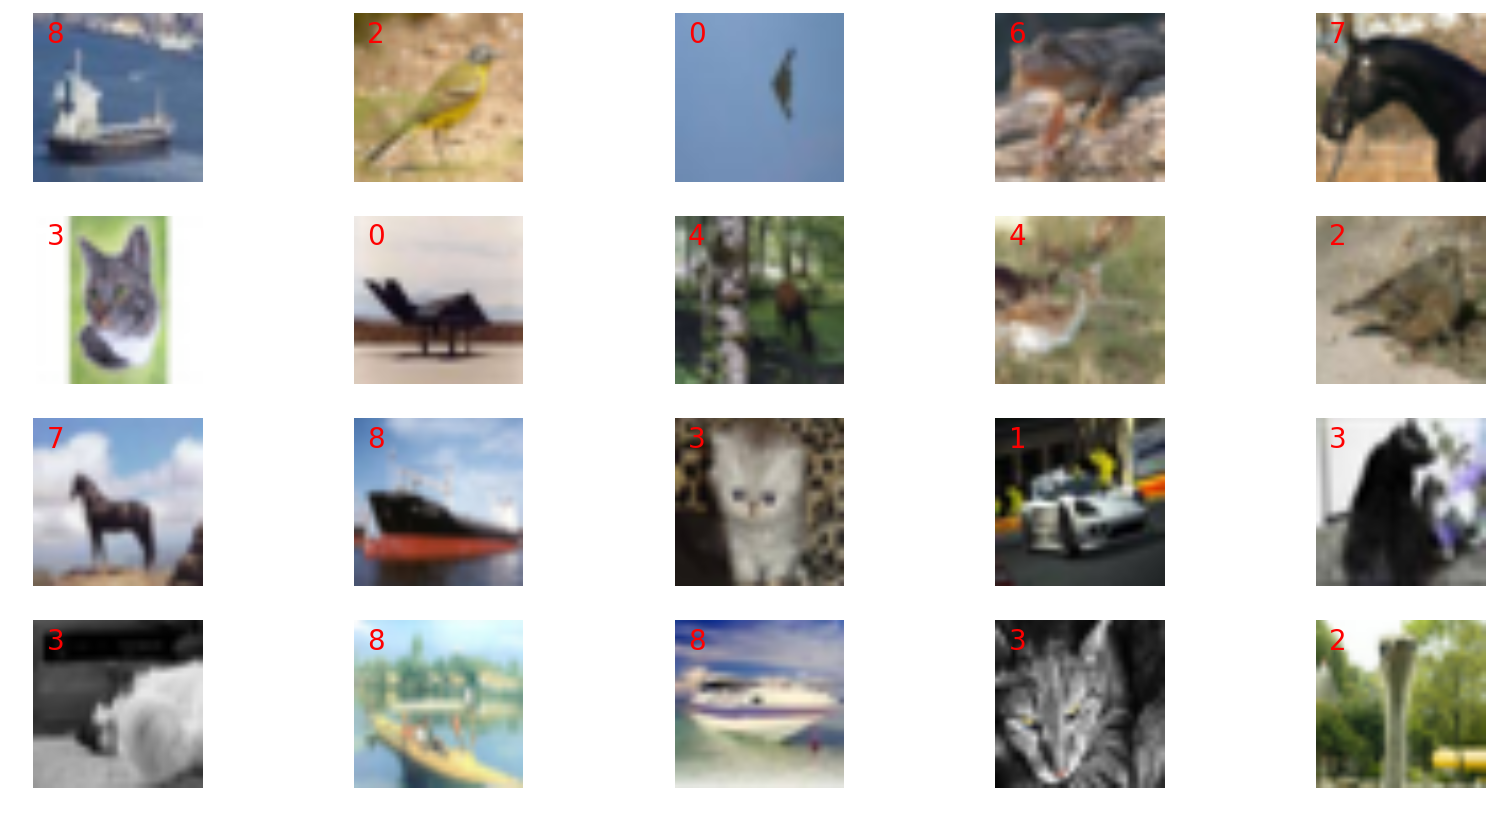

In [31]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Visualize 20 examples picked randomly from train dataset
ls = [random.randint(0, len(y_train)) for i in range(20)]
visualize_random_images(list_imgs=ls, X_dataset=X_train, y_dataset=y_train)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [32]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

#X_train_extra, y_train_extra =  data_augmentation(X_train, y_train, augm_nbr=4000, keep_dist = False)

#X_train = np.concatenate( ( X_train, X_train_extra.astype('uint8') ), axis=0)
#y_train = np.concatenate( (y_train, y_train_extra), axis=0 )

print('After Augmentation')
print('X_train: ',X_train.shape,'\nY_train: ',y_train.shape, '\nX_test: ',X_test.shape
      ,'\nY_test: ',y_test.shape)

X_train, X_validation,y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2, random_state=0)

print('\nAfter Split')
print('X_train: ',X_train.shape,'\nY_train: ',y_train.shape, '\nX_test: ',X_test.shape
      ,'\nY_test: ',y_test.shape, '\nX_validation: ',X_validation.shape, '\ny_validation: ', y_validation.shape)
print('image shape: ',X_train[0].shape)

X_train_gray = np.ndarray(shape=(len(X_train),32,32,1))
X_test_gray = np.ndarray(shape=(len(X_test),32,32,1))
X_validation_gray = np.ndarray(shape=(len(X_validation),32,32,1))

for indx, img in enumerate(X_train):    
    X_train_gray[indx] = np.reshape(grayscale(img),(32,32,1))
for indx,img in enumerate(X_test):    
    X_test_gray[indx] = np.reshape(grayscale(img),(32,32,1))
for indx,img in enumerate(X_validation):    
    X_validation_gray[indx] = np.reshape(grayscale(img),(32,32,1))
image_shape = X_train_gray[0].shape

#Mean subtraction preprocessing.
mean = np.mean(X_train_gray)
print(mean)
X_train_gray -= mean
X_test_gray -= mean
X_validation_gray -= mean

print(X_train_gray[0])

After Augmentation
X_train:  (50000, 32, 32, 3) 
Y_train:  (50000,) 
X_test:  (10000, 32, 32, 3) 
Y_test:  (10000,)

After Split
X_train:  (40000, 32, 32, 3) 
Y_train:  (40000,) 
X_test:  (10000, 32, 32, 3) 
Y_test:  (10000,) 
X_validation:  (10000, 32, 32, 3) 
y_validation:  (10000,)
image shape:  (32, 32, 3)
120.491642139
[[[ -12.49164214]
  [ -18.49164214]
  [ -34.49164214]
  ..., 
  [ -46.49164214]
  [ -49.49164214]
  [ -34.49164214]]

 [[ -10.49164214]
  [ -16.49164214]
  [ -14.49164214]
  ..., 
  [ -56.49164214]
  [ -48.49164214]
  [ -37.49164214]]

 [[   5.50835786]
  [  -3.49164214]
  [  -1.49164214]
  ..., 
  [ -99.49164214]
  [ -89.49164214]
  [ -41.49164214]]

 ..., 
 [[ -74.49164214]
  [ -69.49164214]
  [ -55.49164214]
  ..., 
  [ 127.50835786]
  [ 114.50835786]
  [ 124.50835786]]

 [[ -66.49164214]
  [ -66.49164214]
  [ -57.49164214]
  ..., 
  [ 117.50835786]
  [  57.50835786]
  [  40.50835786]]

 [[ -65.49164214]
  [ -69.49164214]
  [ -66.49164214]
  ..., 
  [ 117.5083578

Visualize: After Augmentation
TRAIN SET


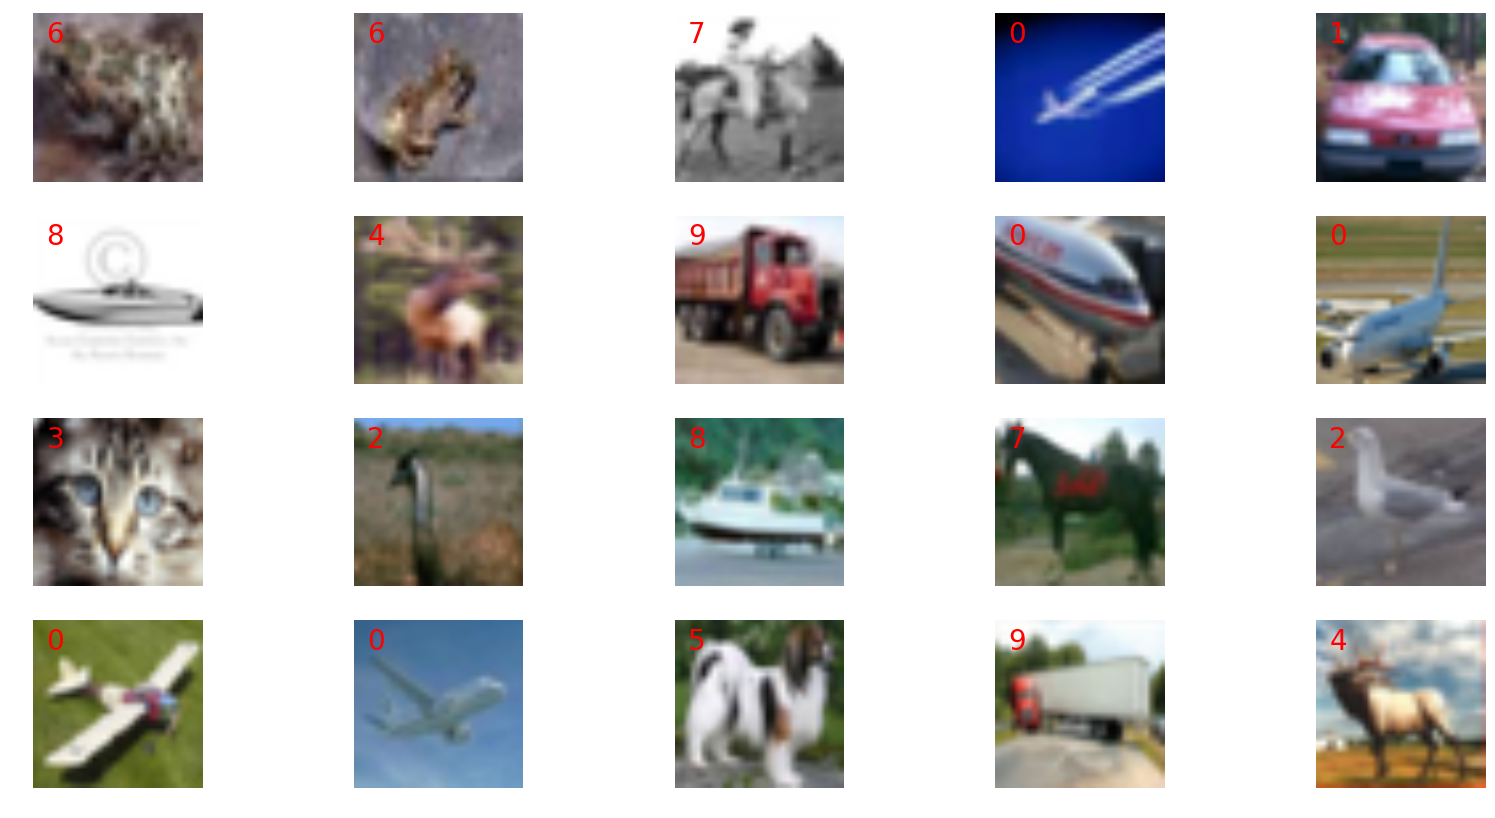

TEST SET


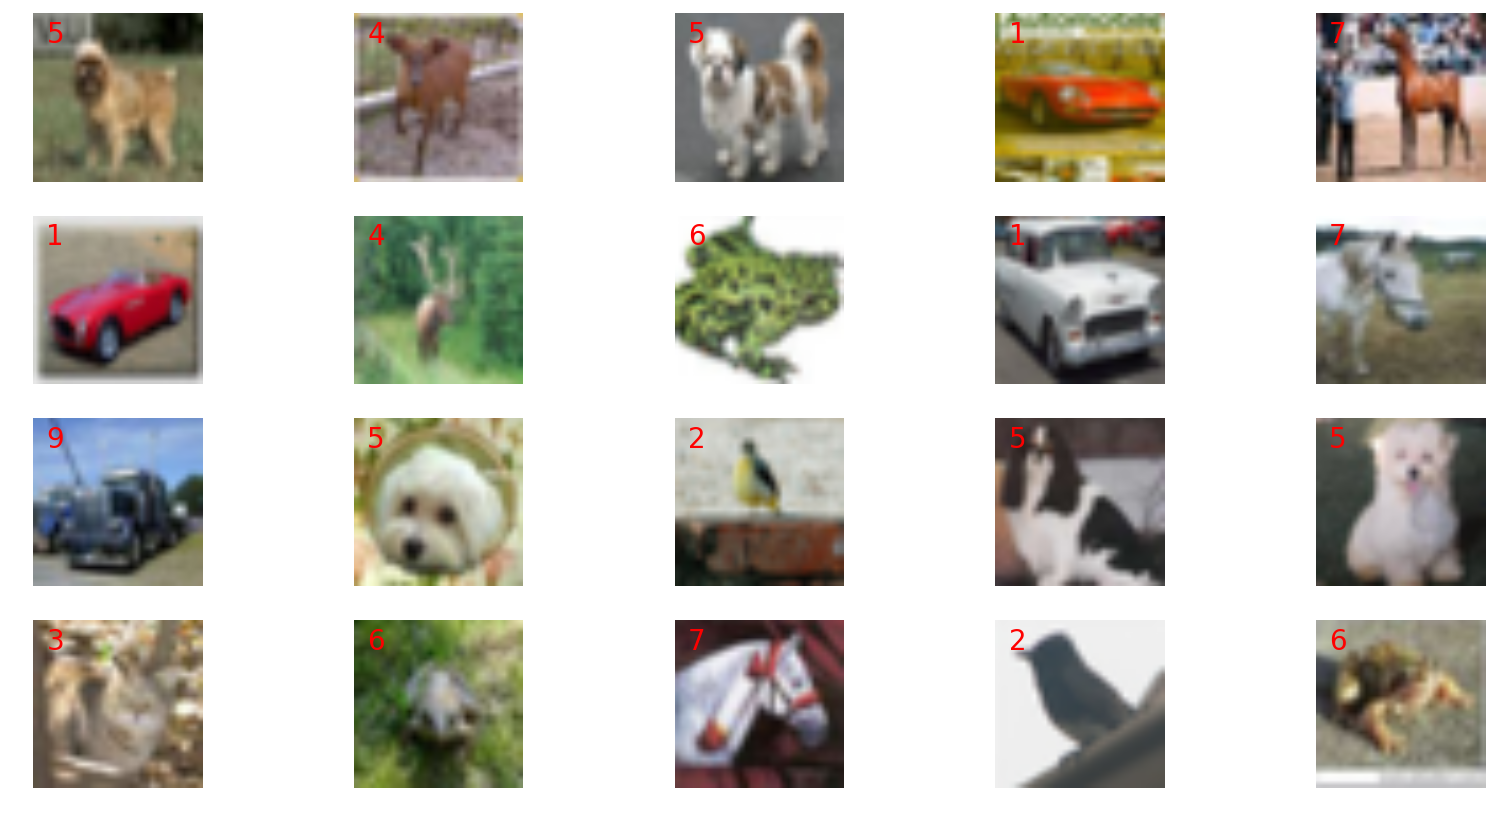

In [33]:
print("Visualize: After Augmentation")
print("TRAIN SET")
# Visualize 20 examples picked randomly from train dataset
ls = [random.randint(0, len(y_train)) for i in range(20)]
visualize_random_images(list_imgs=ls, X_dataset=X_train, y_dataset=y_train)

print("TEST SET")
# Visualize 20 examples picked randomly from train dataset
ls = [random.randint(0, len(y_test)) for i in range(20)]
visualize_random_images(list_imgs=ls, X_dataset=X_test, y_dataset=y_test)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

1) Used only Y channel. The U,V channels doesn't provide any extra feature. We need to learn the shape not the color.

2) I have also done mean substraction preprocessing. Used the training set to calculate a mean image and 
   substrated it from the training, testing and validation set. This allows the data to center around
   0 mean and helps the classifier to find the optimal solution faster. Also it helps to scale down all the
   paramters to a similar range. Although the value is scaled from 0 to 255, its better to scale it down a bit.
 

In [34]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use a1s many code cells as needed.

X_train_gray, y_train = shuffle(X_train_gray, y_train)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1) I have increased the training set by performing data Augmentation. After that I have split the training data set between training and validation set by the ration 3:1. I have put augmentated data in validation set as well because it doesn't matter whether they are agumented or not. They way we augment the data like scaling, rotating etc can be found in the real world as well.

2) Data augmentation is used to generate more data. Scaling, tralation and rotation is used on the existing data images to generate more data. All the class of signs did not have equal number of training data. If we train without having equal number of data in each class, our classifier will be acting partial to the classes which has more data. After data augmentation all the classes has same number of data.



In [35]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

# Hyperparameters
mu = 0
sigma = 0.1    
rate = 0.001     
beta = .01 #for l2 regularization
EPOCHS = 205
BATCH_SIZE = 256

filter_count = 20
filter_count_2 = 60


#Layer 1: Convolutional. Input = 32x32x3. Output = 30x30xfilter_count.
conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, filter_count), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(filter_count))

#Layer 2: Convolutional.Input 15x15xfilter_count Output = 13x13xfilter_count_2.
conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, filter_count, filter_count_2), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(filter_count_2))

#Layer 3: Fully Connected. Input = 2160. Output = 400.
#specified inside LeNet function as it depends on the Layer 2 output.

#Layer 4: Fully Connected. Input = 400. Output = 120.
fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(120))

#Layer 5: Fully Connected. Input = 120. Output = n_classes.
fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, n_classes), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(n_classes))

def LeNet(x):    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 30x30xfilter_count.
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 30x30xfilter_count. Output = 15x15xfilter_count.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Layer 2: Convolutional. Input = 15x15xfilter_count. Output = 13x13xfilter_count_2.
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 13x13xfilter_count_2. Output = 6x6xfilter_count2.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 6x6xfilter_count_2. Output = 2160 when filter_count_2 = 60
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 2160. Output = 400.
    row, col = fc0.get_shape().as_list()
    print('input: ',col)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(col, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1   = tf.nn.relu(fc1)
    fc1   = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 400. Output = 120.
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2   = tf.nn.relu(fc2)
    #fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 120. Output = n_classes.
    logits= tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

1) I have followed the standard lenet architecture. There are two parts. First part consists of two convolution layers. Second part consists of 3 fully connected layer of which the last one is the output layer.

2) First convolution layer has 10 filters of size 3x3. The filter is applied with a stride of 1x1 with 'valid' padding. We use stride 1 so that we don't ignore any information. Although it increase the paramters for the network. The output of the layer is 30x30x20 size of feature map.

3) Then the output is fed to the relu activation function. As this is a non linear function it allows the network to learn complex models. 

4) After that we apply max pooling of size 2x2 with stride 2x2. Here we decrease the paramters of the network and make up for the paramter increasing while choosing stride 1x1 for the filters in 1st convent layer. Then the feature map reduces to 15x15x30 of size.

5) The next layer is another convnet layer which is same as the previous layer. After its max pooling the output is 6x6x60 sized feature map.

6) Then we flatten this feature map to get a 1 dimensional 2160 number of neruons. This is the input of the first fully connected layer.

7) These 2160 neruons are connected to 400 neurons in the fully connected layers.

8) The output of the first FC layer is then fed to Relu activation unit. I add Dropout on this layer with dropout probability 0.5. I do this to prevent overfitting.

9) These 400 neurons are input to the second FC layer. They are connected to 120 neruons and the output is fed to relu. In this layer we do not use Dropout but L2 regularization.

10) The output of these layers are connected to 43 neruons in output layer. Output is our logits.


* Note that we didn't use dropouts in the convnet layers but on the FC layers. The reason is that convnet layers don't do prediction. They extract features from the images. So there is no reason to be any overfitting hence no need for regularization.

* Also note that we didn't use droput on both of the first two FC layers. Instead we used two different regularization technique. The reason is if we use dropout on both the layers then we are effectively turning off way more neurons then we should. Instead we use L2 regularization on second layer so that we still turn off some of the neurons and prevent overfitting on both the layers.

* I have tried putting the droput in second FC layer. But putting in the first one gives better accuracy.



In [36]:
### Train your model here.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]),name='x')
y = tf.placeholder(tf.int32, name='y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
one_hot_y = tf.one_hot(y, n_classes)



logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy + beta * tf.nn.l2_loss(fc2_W))
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

input:  2160


In [37]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, dropout_prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]        
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout_prob})                
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [42]:
#Training
EPOCHS = 40
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_train_gray)
    
    print("Training... Total Epoch: ",EPOCHS)
    print()
    
    for i in range(EPOCHS):
        crossEntropy = 0;
        X_train_gray, y_train = shuffle(X_train_gray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray[offset:end], y_train[offset:end]            
            _, loss_val  = sess.run([training_operation, cross_entropy], feed_dict={x: batch_x, y: batch_y,keep_prob: 0.5})
            crossEntropy += sum(loss_val);            
        print('Evaluating train')    
        train_accuracy = evaluate(X_train_gray, y_train,1.0)
        print('Evaluating test')    
        test_accuracy = evaluate(X_test_gray, y_test,1.0)
        print('Evaluating validation')    
        validation_accuracy = evaluate(X_validation_gray,y_validation,1.0)        
        print("EPOCH {} ...".format(i+1))
        print("train Accuracy = {:.3f}".format(train_accuracy),"test Accuracy = {:.3f}".format(test_accuracy))
        print("validation Accuracy = {:.3f}".format(validation_accuracy))        
        print("Cross_entropy = {:.3f}".format(crossEntropy))        
        if crossEntropy < 900 :
            print('Max Accuracy reached')
            break
        
    saver.save(sess, '.\lenet')
    print("Model saved")

Training... Total Epoch:  40

Evaluating train
Evaluating test
Evaluating validation
EPOCH 1 ...
train Accuracy = 0.847 test Accuracy = 0.649
validation Accuracy = 0.638
Cross_entropy = 29918.541
Evaluating train
Evaluating test
Evaluating validation
EPOCH 2 ...
train Accuracy = 0.876 test Accuracy = 0.650
validation Accuracy = 0.649
Cross_entropy = 27925.177
Evaluating train
Evaluating test
Evaluating validation
EPOCH 3 ...
train Accuracy = 0.889 test Accuracy = 0.644
validation Accuracy = 0.643
Cross_entropy = 26286.526
Evaluating train
Evaluating test
Evaluating validation
EPOCH 4 ...
train Accuracy = 0.890 test Accuracy = 0.643
validation Accuracy = 0.637
Cross_entropy = 24945.943
Evaluating train
Evaluating test
Evaluating validation
EPOCH 5 ...
train Accuracy = 0.913 test Accuracy = 0.655
validation Accuracy = 0.649
Cross_entropy = 23819.964
Evaluating train
Evaluating test
Evaluating validation
EPOCH 6 ...
train Accuracy = 0.912 test Accuracy = 0.647
validation Accuracy = 0.640


In [41]:
#Evaluation
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    validation_accuracy = evaluate(X_validation_gray, y_validation,1)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))

Validation Accuracy = 0.630


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

** Optimizer:     ** AdamOptimizer

** Batch Size:    ** 256   

** Epochs:        ** ~110
I didn't choose this number by guessing. I stopped my model depending on the cross-entropy decreasing rate. I have summed the cross entropy of each epoch. I found that my model doesn't decrease cross entropy after cross entropy reaches the value ~800. After that it doesn't change much. Which means when it first reaches ~800, in there its stable. So if we keep running the model it will start overfitting. So I put a condition to stop the training after we reach cros entropyt < 800. After first time it stopped below 800 then I let it run for another few epochs and saw that cross_entropy stays close to this value. Here I finish my training.

** Learning Rate: ** 0.001

** Beta: ** .02
For L2 regularization. I tried keeping this small so that the regularization doesn't penalize weights too much.

** Droput rate:   ** 0.5
I followed it as suggested in the lessons.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

* I have used the standard Lenet architecture. I tried with this but didn't get satisfactory result. But it was ok. Then I started experimented with the network. I increased the depth which gave me better results. Also I have tried increasing stride for the filter which gave worse performance so I didnt keep it. Then I increased the neuron number in the FC layers. Which also improved the performance a lot.

* I have also tried tuning the learning rate paramter. And found that .001 is the best one for this. By now the result satisfactory.

* Note that I didnt increase another layer of convnet which I would have liked very much. Its because for some problem I didn't use the AWS instance and ran the training in my CPU. That took a lot of time. I'm sure adding another layer would have yielded much better test accuracy.

* Then to make sure the model doesn't overfit I used dropout and L2 regularization in the FC layers. I have experimented with the dropout by putting it in both the first two layers and on the first or in the second. Putting it in both layer yielded worst performance as it turns off many neurons. 

* I have also ran the final model couple of times to see at which point cross-entropy doesn't decrease. I have seen the cross-entropy doesn't go down after it drops between 800-900. So I stop training when reaching that point.


* This model is good for current problem. Although I would have liked it with more convnet layers but I could not because AWS instance was not available for me. In this problem we needed to extract some features from the images. Like different shapes which together may make a specific traffic sign. So instead of seperatedly extracting the feature we use convent layers which does this by itself. 

* The convnet layers extract the image features layer by layer. The features could be different type of shapes etc. After it extracts those features from the images then we feed these features to fully connected layers which actually use those extracted features(e.g the shapes) and then predicts traffic signs which is usual for prediction task with non image data.

* So that is why universal feature extraction layer Convnet layers and prediction layer FC layers using those extracted feature is the perfect architecture for this task.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._

**Answer:**

I have chosen 10 images from internet. Some of the images are rotated and many of them has different type of background like trees, roads, skies which could prove difficult because the backgrounds are foreign shape for the classifier.

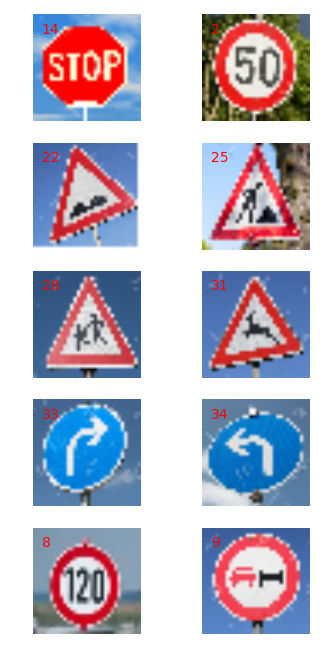

extra image count:  10 
label:  [14  2 22 25 28 31 33 34  8  9]


In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import math

def visualizeImages(list_imgs,label):
    
    #list_imgs = list of index of images to be visualized
    _, ax = plt.subplots( math.floor(len(list_imgs)/2), 2, figsize=(4,8))
    row, col = 0, 0  
    for idx, img in enumerate(list_imgs):        
        ax[row, col].imshow(img)
        ax[row, col].annotate(int(label[idx]), xy=(2, 5), color='red', fontsize='10')

        ax[row,col].axis('off')
        col += 1
        if col == 2:
            row += 1
            col = 0
    plt.show()
    
    

image_list = np.zeros((10, 32, 32, 1), dtype='uint8')
image_visual = np.zeros((10, 32, 32,3), dtype='uint8')
y_extra = np.zeros(10, dtype='uint8') 
indx = 0
for file in os.listdir('Images'):    
    img = cv2.imread('./Images/'+file) #opencv opens images in BGR format
    img = cv2.resize(img,(32,32))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #convert to standard RGB    
    image_visual[indx] = img
    img = np.reshape(grayscale(img),(32,32,1))
    image_list[indx] = img
    classType = file[0:file.find('.')]    
    y_extra[indx] = classType    
    indx = indx+1    
    
visualizeImages(image_visual,y_extra)

print('extra image count: ',len(image_list), '\nlabel: ',y_extra)


In [25]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(image_list, y_extra,1.0)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.800


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model could detect 8 of the 10 images. The accuracy is 80%.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

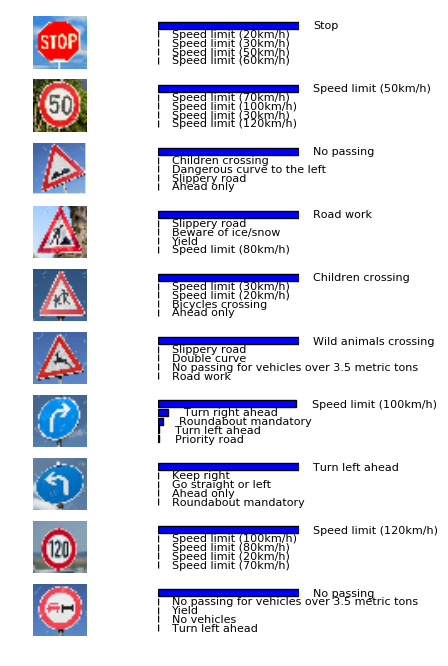

In [27]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

feed_dict = {x: image_list, keep_prob: 1}
k_top = 5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_operation = tf.nn.softmax(logits)
    pred_proba = sess.run(softmax_operation, feed_dict=feed_dict)
    prediction = np.argmax(pred_proba, 1)        
    top_k_values = tf.nn.top_k(softmax_operation, k_top)
    top_k_proba = sess.run([ softmax_operation, top_k_values], feed_dict=feed_dict)        
        
#initialize subplots
_, ax = plt.subplots( len(image_visual), 2, figsize=(4,8))
col_plot = 0

for i in range(len(image_visual)):
    img = image_visual[i]
    ax[i, col_plot].imshow(img)
    ax[i,col_plot].axis('off')
    col_plot += 1
    ax[i, col_plot].barh(-np.arange(k_top),top_k_proba[1][0][i], align='center')
    
    #annotations
    for k in range(k_top):
        text_pos = [top_k_proba[1][0][i][k]+.1, -(k+0.4) ]
        ax[i, col_plot].text( text_pos[0], text_pos[1], sign_names[top_k_proba[1][1][i][k]][1], fontsize=8)
    ax[i,col_plot].axis('off')
    col_plot = 0
plt.show()


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.